# 1) Does basic house information reflect house's description?

## Loading the libraries

In [1]:
import itertools
import matplotlib.pyplot as plt
import myfunction as mf # our function
import numpy as np
import pickle
import re
import requests
import time
import pandas as pd

In [2]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup # HTML data structure
from urllib.request import urlopen # Web client

## Scraping the pages by simple threading

In [ ]:
first_matrix, links = [], []

In [ ]:
origin_time = time.time()

EndPage = 100 # for a total of more than 10000 announcements
for i in range(1,EndPage+1):
    try:
        url = "https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=" + str(i)
        page = urlopen(url)
        time.sleep(0.001)
        soup = BeautifulSoup(page, 'html.parser')
        data = soup.find_all("div", {"class":"listing-item_body--content"})

        # find results within features
        for feature in data:
            feature1 = feature.find('ul',{"class":"listing-features list-piped"})
            children = feature1.findChildren("li" , recursive=False)

            if (len(feature1.find_all("li"))) == 6: # checking if the announcements have enough criteria
                feature2 = mf.extractlink(feature)
                links.append(*feature2)        
                sub_matrix = []
                for child in children:
                    text = child.text.strip().replace('\n','').replace(u'\xa0', u' ').replace('.','')
                    if "A" in text:
                        text = '10' # replace the A piano with 10 (assume that 10 is the average highest floor)
                    elif "R" in text:
                        text = '1'  # replace the R piano with 1 (assumption)    
                    elif  "T" in text or "S" in text:
                        text = '0' # replace the T|S piano with 0 (assume the ground or basement floor)
                    text = re.findall(r"d*\.\d+|\d+", text) #get only the number                
                    if len(text) > 1: 
                        text = text[:1]
                    text = ''.join(text)
                    sub_matrix.append(text)
                if len(sub_matrix) == 6:
                    del sub_matrix[5]
                    first_matrix.append(sub_matrix)
            else:
                pass
    except:
        pass

time_interval = time.time() - origin_time
print(time_interval)

In [ ]:
f = open("first_matrix.pkl","wb")
pickle.dump(first_matrix,f)
f.close()

Now we have the complete first matrix saved. Let's have a look:

In [3]:
with open('first_matrix.pkl', 'rb') as f:
    matrix1 = pickle.load(f)
matrix1[0:10]

[['225000', '2', '50', '1', '1'],
 ['395000', '5', '130', '2', '1'],
 ['3700000', '5', '250', '3', '5'],
 ['850000', '5', '175', '2', '10'],
 ['279000', '3', '110', '1', '0'],
 ['520000', '3', '105', '2', '1'],
 ['269000', '3', '87', '2', '3'],
 ['1050000', '5', '235', '3', '3'],
 ['1800000', '5', '250', '3', '3'],
 ['1650000', '5', '220', '3', '4']]

## Visualize our data in dataframe

In [4]:
df = pd.DataFrame(matrix1, columns = ['price','locali','superficie','bagni','piano'])
df.head()

,price,locali,superficie,bagni,piano
0,225000,2,50,1,1
1,395000,5,130,2,1
2,3700000,5,250,3,5
3,850000,5,175,2,10
4,279000,3,110,1,0


Save our links in another variable:

In [ ]:
f = open("links.pkl","wb")
pickle.dump(links,f)
f.close()

In [5]:
with open('links.pkl', 'rb') as f:
    mylinks = pickle.load(f)

Checking the links

In [6]:
mylinks[0:10]

['https://www.immobiliare.it/53131931-Vendita-Bilocale-viale-Italo-Calvino-Roma.html',
 'https://www.immobiliare.it/69489710-Vendita-Appartamento-via-di-Pietralata-Roma.html',
 'https://www.immobiliare.it/64236874-Vendita-Appartamento-via-della-Tribuna-di-Roma.html',
 'https://www.immobiliare.it/70114842-Vendita-Attico-Mansarda-via-Degli-Orti-Di-Galba-Roma.html',
 'https://www.immobiliare.it/70107928-Vendita-Trilocale-via-Fontanellato-75-Roma.html',
 'https://www.immobiliare.it/70114826-Vendita-Trilocale-via-Genserico-Fontana-11-Roma.html',
 'https://www.immobiliare.it/69613394-Vendita-Trilocale-via-Arnaldo-Cantani-Roma.html',
 'https://www.immobiliare.it/63420032-Vendita-Attico-Mansarda-via-dei-Baullari-Roma.html',
 'https://www.immobiliare.it/69292298-Vendita-Appartamento-via-della-Farnesina-323-Roma.html',
 'https://www.immobiliare.it/68601391-Vendita-Attico-Mansarda-via-Nicolo-Piccolomini-Roma.html']

The next step is to scrape for description matrix of all the links that we'd saved

In [ ]:
mytext = ''
fulltext = []
count = 1
dictionary = {} # a dictionary for annoucement as the key and all the words as list of value
totalcount = {} # a dictionary for announcement as the key and total number of words as value
errorpage = [] # keep track of the error page

In [ ]:
for url in mylinks: # change this to just mylinks to run all the list
    try:
        if (url.startswith('/')):
            url = 'https://www.immobiliare.it' + url
        page = urlopen(url)
        time.sleep(0.001)
        soup = BeautifulSoup(page, 'html.parser')
        description = soup.find('div', attrs={'role':'contentinfo'})
        text = mf.preprocess(description.text)
        value = text.strip().split()
        totalcount.update({'anno'+str(count):len(value)})
        dictionary.update({'anno'+str(count):value})
        fulltext.append(value) # get the full text as list of distinctive words
        count += 1
        mytext += text
    except:
        errorpage.append(count)
        count += 1
#mytext    

Save the error pages' indexes

In [ ]:
f = open("errorpage.pkl","wb")
pickle.dump(errorpage,f)
f.close()

In [7]:
with open('errorpage.pkl', 'rb') as f:
    errorpage = pickle.load(f)

Pop the data of the pages that cannot be loaded

In [8]:
c = 0
for i in errorpage:
    matrix1.pop(i-c)
    c+=1

Saving all the important scraped data that is necessary for our task.<br/>
We can then load them any time for processing:

In [ ]:
f = open("totalcount.pkl","wb")
pickle.dump(totalcount,f)
f.close()

In [9]:
with open('totalcount.pkl', 'rb') as f:
    totalcount = pickle.load(f)

In [ ]:
f = open("mytext.pkl","wb")
pickle.dump(mytext,f)
f.close()

In [10]:
with open('mytext.pkl', 'rb') as f:
    mytext = pickle.load(f)

In [ ]:
f = open("fulltext.pkl","wb")
pickle.dump(fulltext,f)
f.close()

In [11]:
with open('fulltext.pkl', 'rb') as f:
    fulltext = pickle.load(f)

In [ ]:
dictionary = mf.make_indices(dictionary) # indexing our dictionary
dictionary = mf.fullIndex(dictionary) # reverse the index
#save the dictionary into pkl file using pickle
f = open("dictionary.pkl","wb")
pickle.dump(dictionary,f)
f.close()

Checking our corpus

In [41]:
with open('dictionary.pkl', 'rb') as f:
    dictionary = pickle.load(f) # with index

In [42]:
#input = {word: {filename: [pos1, pos2]}, ...}, ...}
#output = {word: {filename: term_count}, ...}, ...}
new_dict = {}
for k, v in dictionary.items():
    sub_dict = {}
    for k1, v1 in v.items():
        term_count = len(v1) # term count in an annoucement
        sub_dict.update({k1 : term_count})
    new_dict.update({k:sub_dict})
    del sub_dict # delete the old sub-dict for the term

In [43]:
doc_count = len(matrix1) # get the total number of announcements
doc_count

11156

Checking total_count of an announcement (announcement 1)

In [44]:
print(mf.total_count('anno1'))

72


## Create a dictionary with TF_IDF score


In [45]:
for k, v in new_dict.items():
    for k1, v1 in v.items():
        v[k1] = mf.tf_idf(v1, mf.total_count(k1), doc_count, mf.contain_count(k)) #change the doc_count accordingly
    new_dict[k] = v
# we have the new_dict with tf-idf score for each word as key

Convert out full set of words (corpus) into a list

In [17]:
set_full = list(set(list(itertools.chain.from_iterable(fulltext)))) #fastest way to flatten the list, making the set and convert back to list
set_full[0:20] #full list of dictionary

['vigna',
 'continuativo',
 'guidato',
 'anastasio',
 'arte',
 'rivestita',
 'largo',
 'oggettivo',
 'semiabitale',
 'why',
 'lasci',
 'hi',
 'einsatz',
 'dellimpiantistica',
 'passe',
 'finestratigrande',
 'caldaiia',
 'inimitabile',
 'fiorita',
 'agevoli']

In [18]:
reverse = mf.fullIndex(new_dict)  # reverse the TF-IDF dictionary

## Creating the second matrix

In [19]:
second_matrix = []
for k, v in reverse.items():
    subtrix = [0] * len(set_full)
    for k1, v1 in v.items():
        subtrix[set_full.index(k1)] = v1
    second_matrix.append(subtrix)
second_matrix.pop(-1)
second_matrix[0:10] # second matrix tf-idf of the problem (run this one we have second matrix)

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


## Using Elbow method to find number of clustering

### Convert the first matrix into float matrix

In [20]:
print(type(matrix1))
print(type(matrix1[1][1]))
matrix1 = np.array(matrix1)
matrix1 = matrix1.astype(np.float)
print(type(matrix1))
print(type(matrix1[1][1]))

<class 'list'>
<class 'str'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>


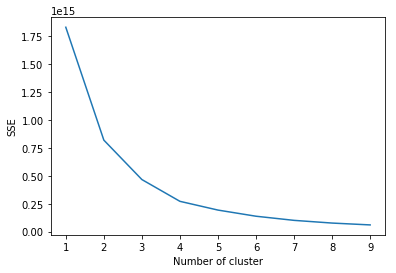

In [21]:
sse = {}
for k in range(1, 10):  # running with at most 10 clusters to check the optimal number
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(matrix1)
    #first_matrix[1] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

We can see in plot, #4# is the optimal number of clusters for our dataset.<br/>
Then we run the Kmeans++ with 4 clusters

In [22]:
kmeans = KMeans(n_clusters=4, max_iter=1000).fit(matrix1)
result1 = kmeans.labels_
result1

array([0, 0, 2, ..., 3, 0, 0])

### Running the KMeans for matrix 2 with 4 clusters

In [23]:
kmeans = KMeans(n_clusters=4, max_iter=1000).fit(second_matrix) #
result2 = kmeans.labels_
result2

array([2, 2, 2, ..., 2, 2, 2])

Then we see the adjusted score for the two clusterings:

In [24]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(result2,result1)

-0.0015234755837962954

The score of less than 0 means that each cluster of information set is "evenly" distributed over all clusters of description set

## Jaccard Similarity

Getting the similarity score between two outputs:

In [25]:
score_list = []
for i in range(len(matrix1)):
    score = mf.jaccard(matrix1[i],second_matrix[i])
    score_list.append(score)

Return the top 3 index in the list

In [26]:
top3 = sorted(range(len(score_list)), key=lambda i: score_list[i])[-3:]
top3

[1684, 3579, 5532]

## Word Cloud

Getting the text of the top 3 similar results

In [27]:
wordcloudx = []
for i in top3:
    text = list(reverse.get('anno'+(str(i+1))).keys())
    text = ' '.join(text)
    wordcloudx.append(text)
wordcloudx

['composto ampio pregio salone riscaldamento camere via vendita piano ingresso cucina doppi servizi ambienti due immobiliari attico gode vista panoramica tre terrazzo rif villa propone palazzina dotato soppalco inoltre sistema ottime condizioni stato completamente ristrutturato climatizzato e piani superiore panoramico parte cupola san pietro pertinenza finemente splendida finiture splendido il cabina armadio perimetrale giovanni centralizzato tinello segue arioso infatti re ad ripostigli castelli romani elettrico tipo impianti elettrica soffitta luminosissimo meraviglioso norma richiesta basilica f lais irrigazione idraulico pergotenda certificazione acque contabilizzato ag stella filodiffusione imm intermed consulenze alessia clitunno ze campello scorgono paesaggio addolcimento',
 'complesso composto ampio salone camere via gradevole ben proponiamo vendita posto piano ingresso matrimoniali cucina doppi servizi ascensore quinto molto luminoso gode tre affaccio terrazzino quartiere pal

In [28]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["piano", "via","la"])

Creating a word cloud with our full text

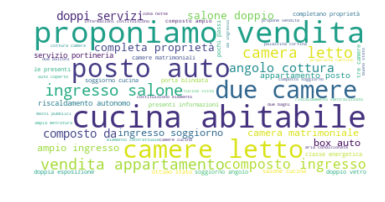

In [29]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(mytext)
# Display the generated image:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_aspect(1)
plt.axis("off")
plt.show()

Importing the image to fill in the text:

In [30]:
house_mask = np.array(Image.open("images.png"))
house_mask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [31]:
def transform_format(val):
    if val == 1:
        return 255
    else:
        return val

In [32]:
transformed_house_mask = np.ndarray((house_mask.shape[0],house_mask.shape[1]), np.int32)
for i in range(len(house_mask)):
    transformed_house_mask[i] = list(map(transform_format, house_mask[i]))
transformed_house_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

### Creating word clouds for 3 most similar couples:

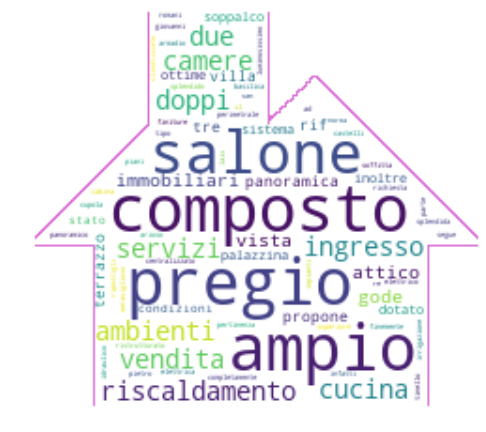

In [33]:
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=100, mask=transformed_house_mask,
               stopwords=stopwords, contour_width=1, contour_color='orchid')

# Generate a wordcloud
wc.generate(wordcloudx[0])

# show
plt.figure(figsize=[8,8])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

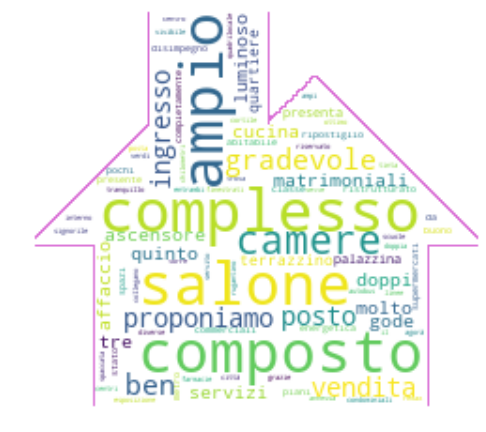

In [34]:
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=100, mask=transformed_house_mask,
               stopwords=stopwords, contour_width=1, contour_color='orchid')

# Generate a wordcloud
wc.generate(wordcloudx[1])

# show
plt.figure(figsize=[8,8])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

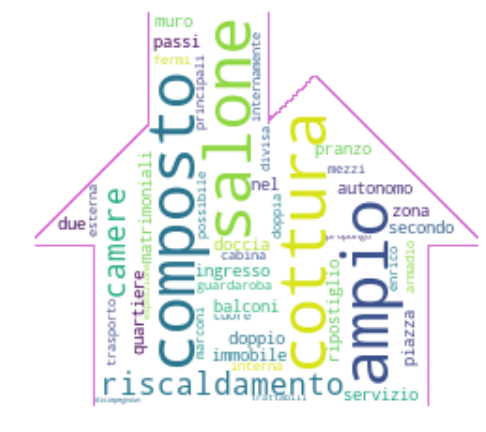

In [35]:
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=100, mask=transformed_house_mask,
               stopwords=stopwords, contour_width=1, contour_color='orchid')

# Generate a wordcloud
wc.generate(wordcloudx[2])

# show
plt.figure(figsize=[8,8])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Bonus Clustering
## Implement K-mean from scratch

In [36]:
class KMeans():

    def updateClusters(self):
        # assign each observation to the closest centroid
        clus = {i : [] for i in range(self.k)}
        for i in range(self.m):
            d = np.sum((self.X[i] - self.centroids)**2, axis = 1)
            clus[np.argmin(d)] += [i]
        self.clustering = clus

    def updateCentroids(self):
        for i in range(self.k):
            self.centroids[i] = np.mean(self.X[self.clustering[i]], axis = 0)

    def __init__(self, X, k):
        #1. Select k points at random from X
        #2. while centroids not stable: reassign and recompute
        self.X, self.k = X, k
        self.m, self.d = X.shape
        self.centroids = X[np.random.choice(self.m,k,replace = False)]
        self.iter = 0
        self.max_itr = 1000
        while True:
            self.updateClusters()
            oldCentroids = self.centroids.copy()
            self.updateCentroids()
            self.iter += 1
            if (self.centroids == oldCentroids).all() or self.iter >= self.max_itr:
                break
            # if self.centroids = newCentroids, then break
        
    def label(self):
        self.label = [0] * self.m
        for k, v in self.clustering.items():
            for i in v:
                self.label[i] = k
        return self.label            

Run our class KMeans for matrix1:

In [37]:
our_result1 = KMeans(matrix1, 4)
our_result1 = our_result1.label()

Then check the clustering between the two methods:

In [38]:
adjusted_rand_score(our_result1,result1)

0.9912861667403449

As we can see, the score is very close to 1, which indicates that the function KMeans++ from library sklearn and our own function give almost similar result.<br/>
Now repeating the steps to matrix 2:

In [39]:
second_matrix = np.asarray(second_matrix)

In [40]:
our_result2 = KMeans(second_matrix, 4)
our_result2 = our_result2.label()
adjusted_rand_score(our_result2,result2)

0.25045897933135775

Once again we see the positive relationship, indicating that each cluster of our result is related to the other's in some way. However in this case for the second matrix, the relationship is not so closely linked